In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [0]:
# set paths
data_path = Path('/data')
colour_path = data_path/'colour'
bw_path = data_path/'bw'

# Create black and white images

In [0]:
def conv_to_bw(img_path, bw_path):
    """
    Opens a colour image, then save as black and white 
    """
    save_name = f'{img_path.stem}_bw{img_path.suffix}'
    img = open_image(img_path, convert_mode='L')
    img.save(bw_path/save_name)

In [0]:
# convert all colour photos to black and white, save in black and white folder
for img_path in colour_path.iterdir():
    conv_to_bw(img_path, bw_path)

# Create Dataset

In [ ]:
src = ImageImageList.from_folder(bw_path).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs, size):
    """
    Create batches of input(bw img), output(colour img) pairs
    """
    data = (src.label_from_func(lambda x: colour_path/f'{str(x.stem.split("_")[0])}{x.suffix}')
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
bs = 20
size = 256
bs, size

(20, 256)

In [0]:
data = get_data(bs, size)

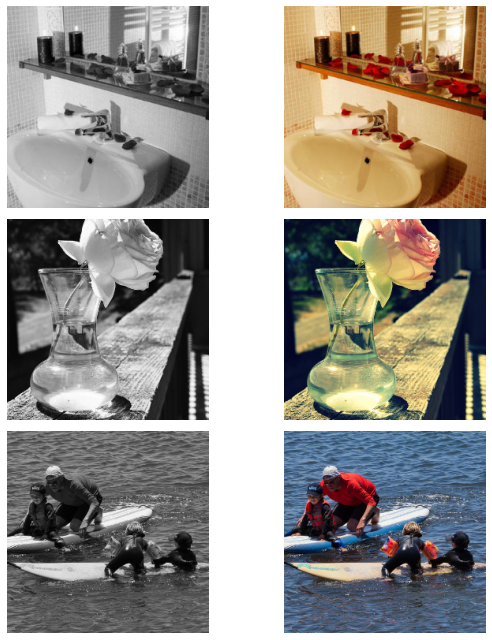

In [10]:
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

# Feature Loss

This model uses Feature loss as implemented by fastai. Feature loss compares the "features" of the generated output of the network with the target.

The features are compared by running both the generated output and the target through a vgg16 network pretrained on imagenet.

The activations are compared in the "feature layers" of the vgg16 network (not the output layers). Comparison via l1 or MSE, know as the base loss.

Feature loss is based on the perceptual loss paper https://arxiv.org/abs/1603.08155. The image below is from that paper.

<img src=https://github.com/Jack-0-0/Adding-Colour-To-Black-and-White-Images/blob/master/imgs/perceptual_loss.jpg?raw=true width="500">

In [0]:
def gram_matrix(x):
    """
    Return a gram matrix.
    Created by flattening input batch and channel (from 4 rank to 3 rank tensor)
    Then multiply flattened input by its transpose and normalise 
    """
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat # pretrained model, which contains the features
        self.loss_features = [self.m_feat[i] for i in layer_ids] # layers in the model which have features to create the losses
        self.hooks = hook_outputs(self.loss_features, detach=False) # hook outputs of the features
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x) # run model
        return [(o.clone() if clone else o) for o in self.hooks.stored] # return activations in hooked feature layers
    
    def forward(self, input, target):
        """
        Returns sum of losses:
          pixel (l1 or MSE) loss
          feature losses (from vgg)
          gram loss
        """
        out_feat = self.make_features(target, clone=True) # find feature activations for target
        in_feat = self.make_features(input) # find feature activations for generated output
        self.feat_losses = [base_loss(input,target)] # calculate loss between the pixels of the generated o and target
        self.feat_losses += [base_loss(f_in, f_out) * w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)] # add the loss of the features
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
# set the base loss to l1
base_loss = F.l1_loss
# create pretrained vgg model
# vgg16_bn(True).features contains the convolutional part of the model
# do not need the head (classification layers)
# .cuda() puts it onto GPU
# .eval() puts it into evaluation mode, as not training it
vgg_m = vgg16_bn(True).features.cuda().eval()
# requires_grad is turned off, as do not want to update the weights, just using it to work out feature loss
requires_grad(vgg_m, False)
# enumerate through the children of the vgg model, find the max pooling layers
# max pooling layers indicate where the grid size changes
# want to compare features just before the grid size changes
# hence take i-1
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
# layer numbers of features before grid size changes
# where we want to grab features from
blocks 

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


[5, 12, 22, 32, 42]

In [18]:
# look at layers of features before grid size changes
# check all are relu activation layers
[vgg_m[i] for i in blocks]

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [0]:
# feature loss
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [21]:
# set architecture
arch = models.resnet34
# create learner
learn = unet_learner(data, 
                     arch, 
                     wd=wd, 
                     loss_func=feat_loss, # using feature loss function using pretrained vgg model
                     callback_fns=[LossMetrics, partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.001, patience=6)],# LossMetrics print out all the different layers losses
                     blur=True, 
                     norm_type=NormType.Weight)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 2.51E-02


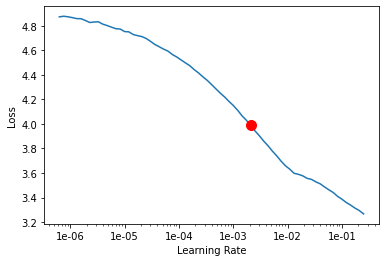

In [0]:
# find learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# set learning rate, choose value from steepest descent in plot above
lr = 1e-2

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycles=10):
    learn.fit_one_cycle(cycles, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=7, imgsize=5)

In [0]:
# start with training the downsampling path of the unet only (upsampling frozen)
do_fit(path/'1a', slice(lr), pct_start=0.9, cycles=100)

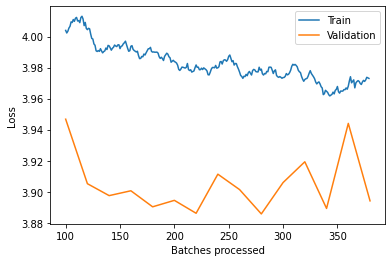

In [0]:
# plot losses
learn.recorder.plot_losses(skip_start=100)

In [0]:
# load saved model
learn.load('1a')

In [0]:
# unfreeze the model
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 3.31E-05


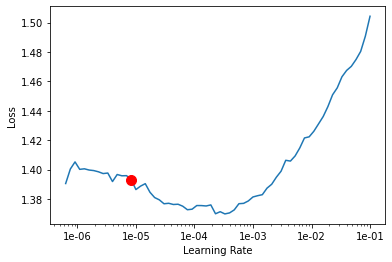

In [0]:
# find learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# set learning rate, choose value from steepest descent in plot above
lr = 8e-6

In [0]:
do_fit('1b', slice(lr), cycles=100)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.398065,1.448150,0.219075,0.142968,0.178118,0.089379,0.247340,0.387950,0.183321,26:57
1,1.389736,1.447252,0.219105,0.143179,0.178332,0.089479,0.246402,0.387436,0.183318,16:23
2,1.393165,1.447822,0.219132,0.142807,0.177997,0.089347,0.247394,0.387905,0.183240,16:24
3,1.380723,1.443883,0.218135,0.142546,0.177617,0.089246,0.246793,0.386355,0.183191,16:21
4,1.399585,1.443967,0.218152,0.142487,0.177644,0.089280,0.246821,0.386414,0.183169,16:23
5,1.382846,1.442139,0.218462,0.142665,0.177770,0.089289,0.245568,0.385299,0.183087,16:28
6,1.390793,1.440933,0.217741,0.141932,0.177136,0.089178,0.246831,0.384971,0.183144,16:32
7,1.391745,1.440503,0.217554,0.141943,0.177133,0.089199,0.246682,0.384779,0.183214,16:25
8,1.387898,1.440506,0.217588,0.142280,0.177446,0.089234,0.245771,0.384987,0.183200,16:27
9,1.381127,1.439362,0.217960,0.142549,0.177641,0.089280,0.244592,0.384152,0.183189,16:24


Epoch 26: early stopping
Buffered data was truncated after reaching the output size limit.